# Code

In [1]:
import pandas as pd
import os
import time
import numpy as np
import sys
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '..')
import dataset.preprocessing as utils
from config import *

### Pre-processing

In [2]:
human_annotations = utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_hs.txt'), columns_to_drop = ['Unnamed: 0', 'transcript_biotype', 'external_gene_name', '5utr', '3utr', 'cds', 'ID'])
mouse_annotations = utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_mm.txt'), columns_to_drop = ['Unnamed: 0', 'transcript_biotype', 'external_gene_name', '5utr', '3utr', 'cds', 'ID'])
annotations = pd.concat([human_annotations, mouse_annotations], axis = 0)
annotations['protein_coding'] = False
annotations.loc[ annotations['gene_biotype'] == 'protein_coding', 'protein_coding'] = True

In [3]:
info = utils.read_dataframe(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), columns_to_drop = ['Unnamed: 0'])

In [4]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)
        
all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}

all_interactions = all_interactions.filter(['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'experiment', 'name'], axis = 1)

all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

In [5]:
merged = all_interactions.merge(info, on = 'name')

assert (merged.tr1 == merged.chrom_1).all()
assert (merged.tr2 == merged.chrom_2).all()
assert (merged.x1 == merged.start_1).all()
assert (merged.x2 == merged.end_1).all()
assert (merged.y1 == merged.start_2).all()
assert (merged.y2 == merged.end_2).all()
assert (merged.strand_1 == merged.strand_2).all()
assert set(merged.strand_1) == {'+'}

merged = merged.drop(['chrom_1', 'chrom_2', 'start_1', 'end_1', 'start_2', 'end_2', 'strand_1', 'strand_2',
             'score', 'external_gene_name_1', 'external_gene_name_2', 'chrom_1_localization', 'chrom_2_localization', 
            'gene_biotype_1', 'gene_biotype_2'], axis = 1)

In [6]:
ann = annotations[['ensembl_gene_id', 'ensembl_transcript_id', 'length', 'protein_coding']]

merged = merged.merge(ann, left_on = 'tr1', right_on = 'ensembl_transcript_id').rename(
{'ensembl_gene_id':'gene1', 'length': 'length1', 'protein_coding':'protein_coding1'}
, axis = 1)

merged = merged.drop(['ensembl_transcript_id'], axis = 1)

merged = merged.merge(ann, left_on = 'tr2', right_on = 'ensembl_transcript_id').rename(
{'ensembl_gene_id':'gene2', 'length': 'length2', 'protein_coding':'protein_coding2'}
, axis = 1)

merged = merged.drop(['ensembl_transcript_id'], axis = 1)

assert (merged.ensembl_gene_id_1 == merged.gene1).all()
assert (merged.ensembl_gene_id_2 == merged.gene2).all()
merged = merged.drop(['ensembl_gene_id_1','ensembl_gene_id_2', 'name'], axis = 1)

In [7]:
all_transcript_ids = set(merged.tr1).intersection(merged.tr2)
annotations = annotations[annotations.ensembl_transcript_id.isin(all_transcript_ids)]
assert annotations.shape[0] == len(all_transcript_ids)

In [8]:
annotations = annotations.rename({'ensembl_gene_id':'gene_id'}, axis = 1)

annotations.loc[ annotations['UTR5'] == '/', 'UTR5'] = np.nan
annotations.loc[ annotations['CDS'] == '/', 'CDS'] = np.nan
annotations.loc[ annotations['UTR3'] == '/', 'UTR3'] = np.nan

assert annotations[annotations['UTR3'].isna()]['UTR5'].isna().all()
assert annotations[annotations['UTR3'].isna()]['CDS'].isna().all()
assert annotations[annotations['UTR5'].isna()]['CDS'].isna().all()

species = pd.concat([
    merged[['tr1', 'specie']].rename({'tr1':'ensembl_transcript_id'}, axis = 1),
    merged[['tr2', 'specie']].rename({'tr2':'ensembl_transcript_id'}, axis = 1)
], axis = 0).drop_duplicates().reset_index(drop = True)

merged = merged.drop(['specie'], axis = 1)

annotations = annotations.merge(species)

annotations.loc[ annotations['specie'] == 'hs', 'specie'] = "{'hs'}"
annotations.loc[ annotations['specie'] == 'mm', 'specie'] = "{'mm'}"

annotations = annotations.rename({'specie':'species_set'}, axis = 1)

assert len(annotations.gene_id.unique()) == len(annotations.ensembl_transcript_id.unique()) == annotations.shape[0]
assert set(merged.tr1).intersection(merged.tr2) == set(annotations.ensembl_transcript_id)

In [9]:
merged = merged.rename({'gene1':'gene_id1', 'gene2':'gene_id2'}, axis = 1)

merged[['couples', 'need_to_swap']] = merged[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)

def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['length1', 'length2']] = (df.loc[where, ['length2', 'length1']].values)
    df.loc[where, ['tr1', 'tr2']] = (df.loc[where, ['tr2', 'tr1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df.loc[where, ['protein_coding1', 'protein_coding2']] = (df.loc[where, ['protein_coding2', 'protein_coding1']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    print(f"{n_duplicates} interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)")
    return df

merged = swap_genes_if_needed(merged)

0 interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)


In [12]:
merged['w'] = merged['x2'] - merged['x1']
merged['h'] = merged['y2'] - merged['y1']
merged = merged.drop(['tr1', 'tr2', 'y2', 'x2'], axis = 1).rename(
    {'gene_id1':'gene1', 'gene_id2':'gene2', 
     'protein_coding1':'protein_coding_1', 'protein_coding2':'protein_coding_2',
     'length1':'length_1', 'length2':'length_2',
    }, axis = 1)

merged['interacting'] = True

merged = merged[['couples', 'gene1', 'gene2', 'interacting', 'length_1', 'length_2', 
                 'protein_coding_1', 'protein_coding_2', 'x1', 'y1', 'w', 'h', 'experiment']]

In [14]:
map_name = {'ricseq': 'hs_RIC-seq__HeLa_merge.InterGene.arms', 'mario':'mm_MARIO__mES'}

ricseq = merged[merged.experiment == map_name['ricseq']].drop('experiment', axis = 1).reset_index(drop = True)
mario = merged[merged.experiment == map_name['mario']].drop('experiment', axis = 1).reset_index(drop = True)

### Clean bounding boxes of df interactions

In [74]:
how = 'mario'
assert how in ['ricseq', 'mario']

In [75]:
if how=='ricseq':
    int_or = ricseq
    
elif how == 'mario':
    int_or = mario

    
#36 min ricseq
diz_int = {}
idx = 0
for couple in tqdm(int_or.couples.unique()):
    subset = int_or[int_or.couples == couple]
    list_of_boxes = subset.filter(['x1', 'y1', 'w', 'h']).values.tolist()
    new_list_of_boxes = utils.clean_bounding_boxes(list_of_boxes)
    row = int_or[int_or.couples == couple].iloc[0]
    for box in new_list_of_boxes:
        d = dict(row)
        d['x1'] = box[0]
        d['y1'] = box[1] 
        d['w'] = box[2]
        d['h'] = box[3]
        diz_int[idx] = d
        idx+=1
df_int = pd.DataFrame.from_dict(diz_int, 'index').rename({'gene_id1':'gene1', 'gene_id2':'gene2'}, axis = 1)

if how=='ricseq':
    int_or = ricseq
    
elif how == 'mario':
    int_or = mario

  0%|          | 0/990 [00:00<?, ?it/s]

In [76]:
assert len(int_or.couples.unique()) == len(df_int.couples.unique())
print(f'#interazioni prima {int_or.shape[0]}, #interazioni dopo: {df_int.shape[0]}')
df_int.to_csv(os.path.join(processed_files_dir, f'full_{how}_info_interactions.csv'), index = False)

#interazioni prima 993, #interazioni dopo: 993


In [77]:
ricseq = pd.read_csv(os.path.join(processed_files_dir, f'full_ricseq_info_interactions.csv'))
mario = pd.read_csv(os.path.join(processed_files_dir, f'full_mario_info_interactions.csv'))

### Now I have to create negatives

In [42]:
def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)

In [43]:
if how=='ricseq':
    df_pairs_full = ricseq[['couples','gene1', 'gene2']].rename({'couples':'positive'}, axis = 1)
    
elif how == 'mario':
    df_pairs_full = mario[['couples','gene1', 'gene2']].rename({'couples':'positive'}, axis = 1)

In [44]:
how_many_negatives_per_positive = 2 

for i in range(how_many_negatives_per_positive):
    df_pairs_full['gene2'] = df_pairs_full.sample(frac=1, replace=False, random_state=42).reset_index(drop = True)['gene2']
    df_pairs_full[f'negative{i}'] = df_pairs_full['gene1'] + '_' + df_pairs_full['gene2']
    
df_pairs_full = pd.concat([
    df_pairs_full[['positive', 'negative0']].rename({'negative0':'negative'}, axis = 1),
    df_pairs_full[['positive', 'negative1']].rename({'negative1':'negative'}, axis = 1)
], axis = 0)

df_pairs_full['negative'] = df_pairs_full['negative'].apply(order_genes)
df_pairs_full['positive'] = df_pairs_full['positive'].apply(order_genes)

In [45]:
to_drop = set(df_pairs_full['positive']).intersection(df_pairs_full['negative'])

print('how many to drop', len(to_drop))

df_pairs_full = df_pairs_full[~df_pairs_full['negative'].isin(to_drop)]

print(f'We have {len(set(df_pairs_full.positive))} pairs interacting (they can have multiple interactions) \n')
print(f'We have {len(set(df_pairs_full.negative))} pairs not interacting \n')

how many to drop 10758
We have 88148 pairs interacting (they can have multiple interactions) 

We have 167198 pairs not interacting 



#### Drop all the negative interactions that are seen positive in the other experiments

In [46]:
prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

print('how many to drop', len(df_pairs_full[df_pairs_full.negative.isin(prohibited_couples['id'])]))

df_pairs_full = df_pairs_full[~df_pairs_full.negative.isin(prohibited_couples['id'])].reset_index(drop = True)

how many to drop 1165


In [47]:
if how == 'ricseq':
    df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_RICSEQ.csv'), index = False)
elif how == 'mario':
    df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_MARIO.csv'), index = False)

In [48]:
df_neg = df_pairs_full[['negative']].drop_duplicates().reset_index(drop = True)
df_neg[['gene1', 'gene2']] = df_neg['negative'].str.split('_', expand = True)
df_neg = df_neg.rename({'negative':'couples'}, axis = 1)

In [50]:
df_neg

,couples,gene1,gene2
0,ENSG00000136153_ENSG00000172346,ENSG00000136153,ENSG00000172346
1,ENSG00000145391_ENSG00000188229,ENSG00000145391,ENSG00000188229
2,ENSG00000167325_ENSG00000258634,ENSG00000167325,ENSG00000258634
3,ENSG00000128595_ENSG00000167325,ENSG00000128595,ENSG00000167325
4,ENSG00000148187_ENSG00000167325,ENSG00000148187,ENSG00000167325
...,...,...,...
166226,ENSG00000188512_ENSG00000204673,ENSG00000188512,ENSG00000204673
166227,ENSG00000239256_ENSG00000245532,ENSG00000239256,ENSG00000245532
166228,ENSG00000235400_ENSG00000245532,ENSG00000235400,ENSG00000245532
166229,ENSG00000136717_ENSG00000224104,ENSG00000136717,ENSG00000224104


In [38]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv')) #final_df_RANDOM
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

In [39]:
df.columns

Index(['couples', 'gene1', 'gene2', 'interacting', 'length_1', 'length_2',
       'protein_coding_1', 'protein_coding_2', 'x1', 'y1', 'w', 'h'],
      dtype='object')

In [74]:
df_hub = utils.read_dataframe(os.path.join(original_files_dir, 'hub.table.paris.txt'), columns_to_drop = ['Unnamed: 0','gene_name']).rename({'cell_line': 'cell_line_set',
                                                                                                                                                    'degree':'n_interactors',
                                                                                                                                                    'gene_type': 'gene_type_set',
                                                                                                                                                    'species': 'species_set'}, axis = 1)
tx = utils.read_dataframe(os.path.join(original_files_dir,'tx_regions.ens99.txt'), columns_to_drop = ['Unnamed: 0']).rename({'ensembl_gene_id': 'gene_id'}, axis = 1)
cc = utils.read_dataframe(os.path.join(original_files_dir,'controls_controlled.hub.txt'), columns_to_drop = ['Unnamed: 0'])
int_or = utils.read_dataframe(os.path.join(original_files_dir, 'rise_paris_tr.new.mapped_interactions.tx_regions.txt'))
int_or = int_or.drop_duplicates().reset_index(drop = True)
df_genes = df_hub.merge(tx, on = 'gene_id')
assert df_genes.shape[0] == df_hub.shape[0]

In [8]:
df_pairs_full = utils.obtain_df_pos_controls(cc)[['positive']].drop_duplicates().reset_index(drop = True)

In [11]:
rgx = df_pairs_full['positive'].str.extractall('(.*)_(.*)').reset_index(drop = True)
df_pairs_full['gene1'], df_pairs_full['gene2'] = rgx[0], rgx[1]

In [13]:
def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)

In [5]:
how_many_negatives_per_positive = 2 
for i in range(how_many_negatives_per_positive):
    df_pairs_full['gene2'] = df_pairs_full.sample(frac=1, replace=False, random_state=42).reset_index(drop = True)['gene2']
    df_pairs_full[f'negative{i}'] = df_pairs_full['gene1'] + '_' + df_pairs_full['gene2']
    
df_pairs_full = pd.concat([
    df_pairs_full[['positive', 'negative0']].rename({'negative0':'negative'}, axis = 1),
    df_pairs_full[['positive', 'negative1']].rename({'negative1':'negative'}, axis = 1)
], axis = 0)

df_pairs_full['negative'] = df_pairs_full['negative'].apply(order_genes)
df_pairs_full['positive'] = df_pairs_full['positive'].apply(order_genes)

In [6]:
to_drop = set(df_pairs_full['positive']).intersection(df_pairs_full['negative'])

print('how many to drop', len(to_drop))

df_pairs_full = df_pairs_full[~df_pairs_full['negative'].isin(to_drop)]

how many to drop 546


In [7]:
print(f'We have {len(set(df_pairs_full.positive))} pairs interacting (they can have multiple interactions) \n')
print(f'We have {len(set(df_pairs_full.negative))} pairs not interacting \n')

We have 80485 pairs interacting (they can have multiple interactions) 

We have 159687 pairs not interacting 



In [8]:
df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM.csv'), index = False)

In [9]:
df_neg = df_pairs_full[['negative']].drop_duplicates().reset_index(drop = True)
df_neg[['gene1', 'gene2']] = df_neg['negative'].str.split('_', expand = True)
df_neg = df_neg.rename({'negative':'couples'}, axis = 1)

### Gene info df

In [10]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

### Clean bounding boxes of df interactions

In [11]:
df_int = pd.read_csv(os.path.join(processed_files_dir, 'full_paris_info_interactions.csv'))

df_int = df_int[['couples', 'gene1', 'gene2', 
                 'interacting', 'length_1', 'length_2',
                 'protein_coding_1', 'protein_coding_2',
                 'x1', 'y1', 'w', 'h']]

In [12]:
df_neg['interacting'] = False
df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_1','protein_coding':'protein_coding_1'} , axis = 1)
df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene2', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_2','protein_coding':'protein_coding_2'} , axis = 1)

In [14]:
assert (set(df_pairs_full.negative) - set(df_neg.couples) == {np.nan})|(set(df_pairs_full.negative) - set(df_neg.couples) == set()) # I have some NaN in the df_pairs_full

In [15]:
df_int1 = df_int[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1',  'w': 'l'}, axis = 1)
df_int2 = df_int[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1',  'h': 'l'}, axis = 1)
df_coord = pd.concat([df_int1, df_int2], ignore_index = True)#.drop_duplicates().reset_index(drop = True)
#df_coord may have duplicates. but this is something I want. If a gene appears more than once, I want it to be sampled according to its distribution.

In [16]:
assert set(df_neg.gene1).union(set(df_neg.gene2)) - set(df_coord.gene) == set()

### Create fake negative interactions

In [17]:
df_coord = df_coord.merge(
    df_genes.filter(['gene_id', 'UTR5', 'CDS', 'UTR3', 'protein_coding'], axis = 1).rename({'gene_id':'gene'}, axis = 1)
)
df_coord['where_c1'] = df_coord.apply(utils.where_interacts, axis = 1)

In [18]:
#127 min
start_time = time.time()
new_cols = df_neg[['couples', 'gene1', 'gene2']].apply(utils.create_fake_coord_neg, axis = 1, args = (df_coord,df_pairs_full,df_int,))
print(f"Total time: {(time.time()-start_time)/60} minutes")

Total time: 127.97081159353256 minutes


In [19]:
new_cols = new_cols.apply(pd.Series).rename({0:'x1', 1:'y1', 2:'w', 3:'h'}, axis = 1)

In [20]:
df_neg = pd.concat([df_neg, new_cols], axis = 1)

In [21]:
df = pd.concat([df_int, df_neg], ignore_index = True, axis = 0)

Now I do checks

In [22]:
#check if it worked
assert (df_neg.x1 <= df_neg.length_1).all()
assert ((df_neg.x1 + df_neg.w) <= df_neg.length_1).all()
assert (df_neg.y1 <= df_neg.length_2).all()
assert ((df_neg.y1 + df_neg.h) <= df_neg.length_2).all()

In [23]:
# 37 min
#check if it worked
start_time = time.time()
for _, row in df_neg.iterrows():
    g1 = row.gene1
    g2 = row.gene2
    assert [row.x1, row.w] in df_coord[df_coord.gene == g1][['c1', 'l']].values
    assert [row.y1, row.h] in df_coord[df_coord.gene == g2][['c1', 'l']].values
    if np.random.rand() < 0.0003: #progress
        print(f"{np.round(_/df_neg.shape[0] * 100, 2)}% in {(time.time()-start_time)/60} minutes")
print(f"Total time: {(time.time()-start_time)/60} minutes")

0.49% in 0.2674432396888733 minutes
1.28% in 0.6839573502540588 minutes
8.14% in 4.317260754108429 minutes
9.92% in 5.259678407510122 minutes
12.7% in 6.731126554807028 minutes
13.63% in 7.224628718694051 minutes
15.42% in 8.172607183456421 minutes
19.99% in 10.593974514802296 minutes
24.2% in 12.827969026565551 minutes
25.07% in 13.286136547724405 minutes
29.36% in 15.51808332602183 minutes
29.55% in 15.614556908607483 minutes
29.64% in 15.656647749741872 minutes
30.76% in 16.20518857638041 minutes
39.27% in 20.353888646761575 minutes
41.51% in 21.44532863299052 minutes
42.41% in 21.88201893965403 minutes
42.77% in 22.05802938143412 minutes
44.75% in 23.02445451418559 minutes
51.54% in 26.332193080584208 minutes
51.82% in 26.468093542257943 minutes
54.11% in 27.58557262420654 minutes
56.94% in 29.00339949131012 minutes
66.4% in 34.024077320098876 minutes
67.42% in 34.567647349834445 minutes
70.07% in 35.96970264116923 minutes
72.13% in 37.05869233210881 minutes
77.01% in 39.6492141405

#### Drop all the negative interactions that are seen positive in the other experiments

In [27]:
prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']

df_int, df_neg = df[df.interacting == True], df[df.interacting == False]

prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)
df_neg = df_neg[~df_neg.couples.isin(prohibited_couples['id'])]

In [28]:
df = pd.concat([df_int, df_neg], ignore_index = True, axis = 0)
df.to_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'), index = False)

# Plots 

### Interaction Length distribution

In [29]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'))

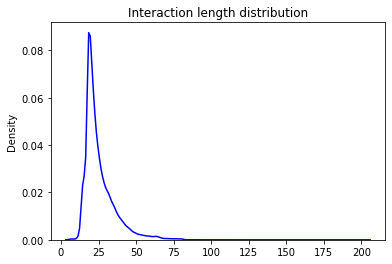

In [30]:
df_int = df[df.interacting]
lengths = list(pd.concat([df_int.w, df_int.h]))
sns.kdeplot(lengths, color = 'blue')
plt.title(f'Interaction length distribution')
plt.show()

In [31]:
treshold = 25
perc = np.round(df_int[(df_int.w > treshold) & (df_int.h > treshold)].shape[0]/df_int.shape[0] * 100, 2)
print(f'If I take only the couples where both interaction regions are > {treshold} bp, I have the {perc}% of the dataset')

If I take only the couples where both interaction regions are > 25 bp, I have the 15.65% of the dataset


### Degree

In [32]:
def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [33]:
gene_count = obtain_gene_count_real(df)

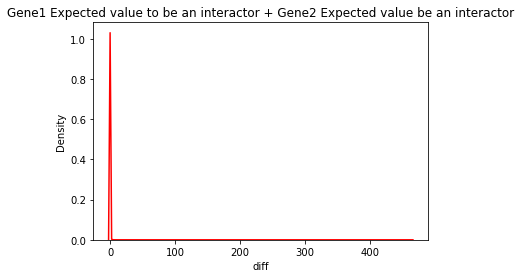

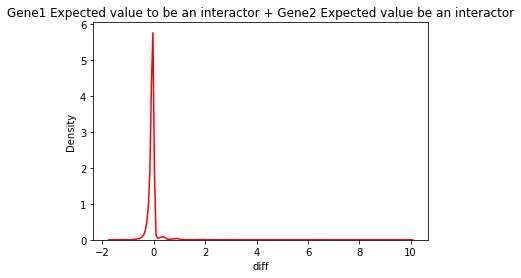

percentage of genes within the tolerance treshold 0.999 %
percentage of data within the tolerance treshold 0.913 %


In [34]:
tolerance = 10

sns.kdeplot(gene_count['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

sns.kdeplot(gene_count[gene_count['diff']<tolerance]['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()


subset = gene_count[(gene_count['diff']<tolerance)&(gene_count['diff']>-tolerance)]
subset_treshold = df[(df.gene1.isin(subset.gene)&df.gene2.isin(subset.gene))]

print(f'percentage of genes within the tolerance treshold {(subset.shape[0] / gene_count.shape[0]):.3f} %')
print(f'percentage of data within the tolerance treshold {(subset_treshold.shape[0] / df.shape[0]):.3f} %')

### CDS-CDS enrichment?

In [36]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv')) #final_df_RANDOM
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))[['gene_id', 'CDS', 'UTR5', 'UTR3']]

In [37]:
def create_interactions_columns(df, df_genes):

    df = df.merge(df_genes, left_on = 'gene1', right_on = 'gene_id')
    df['where_x1'] = 'none'
    df.loc[(df.x1 < df.UTR5), 'where_x1'] = 'UTR5'
    df.loc[(df.x1 >= df.UTR5)&(df.x1 < df.CDS), 'where_x1'] = 'CDS'
    df.loc[(df.x1 >= df.CDS), 'where_x1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    
    df = df.merge(df_genes, left_on = 'gene2', right_on = 'gene_id')
    df['where_y1'] = 'none'
    df.loc[(df.y1 < df.UTR5), 'where_y1'] = 'UTR5'
    df.loc[(df.y1 >= df.UTR5)&(df.y1 < df.CDS), 'where_y1'] = 'CDS'
    df.loc[(df.y1 >= df.CDS), 'where_y1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    return df

def where_interacts(x):
    a,b = sorted([x.where_x1, x.where_y1])
    return a + '-' + b

df = create_interactions_columns(df, df_genes)
df['where'] = df.apply(where_interacts,axis = 1)

In [38]:
def plot_interaction_region(df):
    df_int, df_neg = df[df.interacting == True], df[df.interacting == False]
    
    # PLOT 
    categories = list(set(df_int['where'].value_counts().index).union(df_neg['where'].value_counts().index))

    neg = df_neg['where'].value_counts()
    neg = pd.Series([neg.get(key, 0) for key in categories], index=categories)

    pos = df_int['where'].value_counts()
    pos = pd.Series([pos.get(key, 0) for key in categories], index=categories)

    values1 = pos.values

    values2 = neg.values

    total1 = sum(values1)
    total2 = sum(values2)

    percentages1 = np.array([value / total1 * 100 for value in values1])
    percentages2 = np.array([value / total2 * 100 for value in values2])

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(12, 8))
    bar1 = ax.bar(index, percentages1, bar_width, label='Positive Distribution', color='skyblue')
    bar2 = ax.bar(index + bar_width, percentages2, bar_width, label='Negative Distribution', color='orange')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Percentage')
    ax.set_title('Comparison of Two Distributions')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

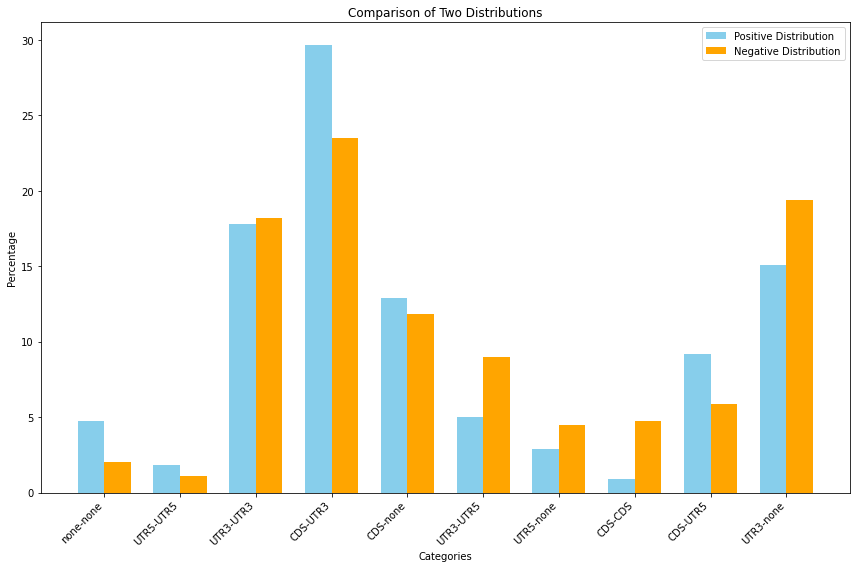

In [39]:
plot_interaction_region(df)

# Train-test-val split

Esegui DEGREE e CDS-CDS ENRICHMENT prima di questo

In [ ]:
from sklearn.model_selection import train_test_split
import dataset.train_test_val_utils as utils
import pickle

In [41]:
df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM.csv')).sample(frac=1).drop_duplicates().reset_index(drop = True)
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

df_pairs_full['gene1'] = df_pairs_full.positive.str.split('_', expand = True)[0]
df_pairs_full['gene2'] = df_pairs_full.positive.str.split('_', expand = True)[1]
df_pairs_full['gene1_neg'] = df_pairs_full.negative.str.split('_', expand = True)[0]
df_pairs_full['gene2_neg'] = df_pairs_full.negative.str.split('_', expand = True)[1]

assert set(df_pairs_full.gene1).union(set(df_pairs_full.gene2)) - set(df_genes.gene_id) == set() 
assert set(df_pairs_full.gene1_neg).union(set(df_pairs_full.gene2_neg)) - set(df_genes.gene_id).union({np.nan}) == set() 

df_pairs_full = df_pairs_full.merge(df_genes[['gene_id', 'species_set']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1)

In [42]:
#circa 5 min
gene_pairs_training, gene_pairs_test, gene_pairs_val = utils.create_or_load_train_test_val(df_pairs_full, save_path = '/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM')

progress around 4.67%
progress around 12.74%
progress around 13.26%
progress around 14.05%
progress around 16.98%
progress around 1.15%
progress around 1.48%
progress around 3.5%
progress around 3.52%
progress around 10.43%
progress around 17.18%
progress around 17.54%
progress around 5.72%
progress around 15.35%
progress around 5.35%
progress around 6.46%
progress around 8.41%
progress around 15.03%
progress around 17.58%
progress around 18.49%
Total time: 5.3302186290423075 minutes


In [43]:
all_possible_pairs = set(df_pairs_full.positive).union(set(df_pairs_full.negative))
assert set(gene_pairs_training).union(set(gene_pairs_val)).union(set(gene_pairs_test)) == all_possible_pairs

print('tot:',len(all_possible_pairs))

print('- - - split - - -')

print('train:', len(set(gene_pairs_training)))

print('test:', len(set(gene_pairs_test)))

print('val:', len(set(gene_pairs_val)))

file_train = os.path.join('/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM', "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
df_train = pd.DataFrame({'couples':gene_pairs_train})
regex = df_train['couples'].str.extractall('(.*)_(.*)').reset_index()
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))
couples_train = set(df_train['couples'])

file_test = os.path.join('/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM', "gene_pairs_test.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
df_test = pd.DataFrame({'couples':gene_pairs_test})
regex = df_test['couples'].str.extractall('(.*)_(.*)').reset_index()
df_test['g1'] = regex[0]
df_test['g2'] = regex[1]
df_test_genes = set(df_test['g1']).union(set(df_test['g2']))
couples_test = set(df_test['couples'])

file_val = os.path.join('/data01/giorgio/RNARNA-NT/dataset/rna_rna_pairs/RANDOM', "gene_pairs_val.txt")
with open(file_val, "rb") as fp:   # Unpickling
    gene_pairs_val = pickle.load(fp)
df_val = pd.DataFrame({'couples':gene_pairs_val})
regex = df_val['couples'].str.extractall('(.*)_(.*)').reset_index()
df_val['g1'] = regex[0]
df_val['g2'] = regex[1]
df_val_genes = set(df_val['g1']).union(set(df_val['g2']))
couples_val = set(df_val['couples'])

tot: 240172
- - - split - - -
train: 172622
test: 34304
val: 33397


In [44]:
couples_test_val =couples_test.union(couples_val)
all_couples = couples_test_val.union(couples_train)

print(len(all_couples))
train_perc = np.round(len(couples_train)/len(all_couples)*100,2)
test_perc = np.round(len(couples_test)/len(all_couples)*100,2)
val_perc = np.round(len(couples_val)/len(all_couples)*100,2)
print(f'La percentuale di coppie nel training è {train_perc}')
print(f'La percentuale di coppie nel test è {test_perc}')
print(f'La percentuale di coppie nel validation è {val_perc}')

test_not_in_train = df_test[~(df_test.g1.isin(df_train_genes) | df_test.g2.isin(df_train_genes))]
test_not_in_train = set(test_not_in_train.couples)
val_not_in_train = df_val[~(df_val.g1.isin(df_train_genes) | df_val.g2.isin(df_train_genes))]
val_not_in_train = set(val_not_in_train.couples)

perc_test_notrain = np.round(len(test_not_in_train)/len(couples_test)*100, 2)
perc_val_notrain = np.round(len(val_not_in_train)/len(couples_val)*100, 2)

print(f'La percentuale di coppie nel test non nel training (rispetto al totale del test set) è {perc_test_notrain}')
print(f'La percentuale di coppie nel validation non nel training (rispetto al totale del validation set) è {perc_val_notrain}')
print(f'Il numero di coppie nel test non nel training è {len(test_not_in_train)}')
print(f'Il numero di coppie nel test (positive) non nel training è  {len(set(df[df.couples.isin(test_not_in_train)&df.interacting].couples))}')
print(f'Il numero di coppie nel val non nel training è {len(val_not_in_train)}')
print(f'Il numero di coppie nel val (positive) non nel training è  {len(set(df[df.couples.isin(val_not_in_train)&df.interacting].couples))}')

240172
La percentuale di coppie nel training è 71.87
La percentuale di coppie nel test è 14.28
La percentuale di coppie nel validation è 13.91
La percentuale di coppie nel test non nel training (rispetto al totale del test set) è 0.82
La percentuale di coppie nel validation non nel training (rispetto al totale del validation set) è 0.64
Il numero di coppie nel test non nel training è 281
Il numero di coppie nel test (positive) non nel training è  86
Il numero di coppie nel val non nel training è 214
Il numero di coppie nel val (positive) non nel training è  89


In [20]:
# df_labels = df[['couples', 'interacting']].drop_duplicates().reset_index(drop = True)
# assert df_labels.shape[0] == len(df['couples'].unique())
# df_labels['interacting'] = df_labels['interacting'].astype('int')


# train, test_val = train_test_split(df_labels, test_size=0.3, random_state=0, stratify=df_labels[['interacting']])
# test, val = train_test_split(test_val, test_size=0.5, random_state=0, stratify=test_val[['interacting']])

# gene_pairs_training = list(set(train.couples))
# gene_pairs_test = list(set(val.couples))
# gene_pairs_val = list(set(test.couples))
# utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

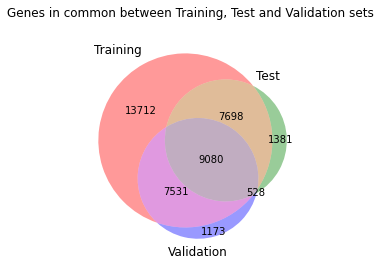

In [45]:
utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

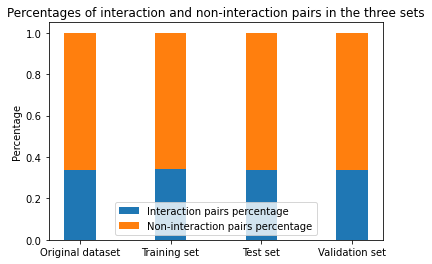

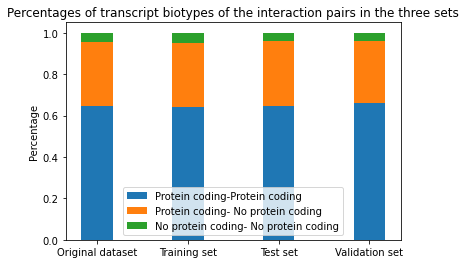

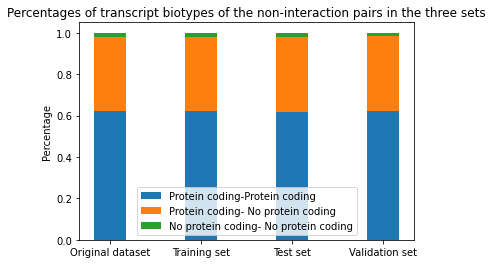

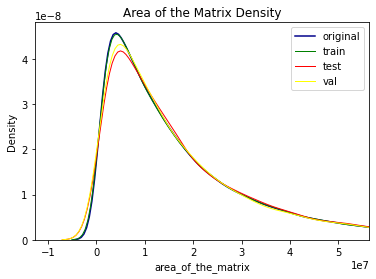

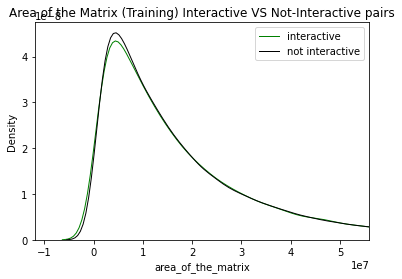

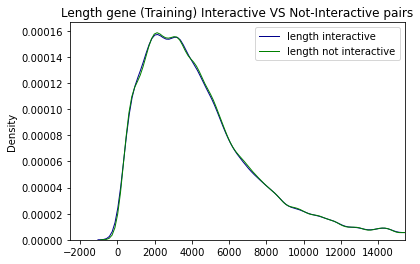

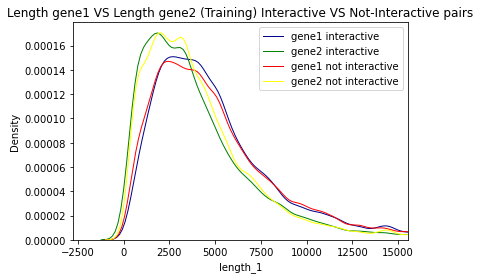

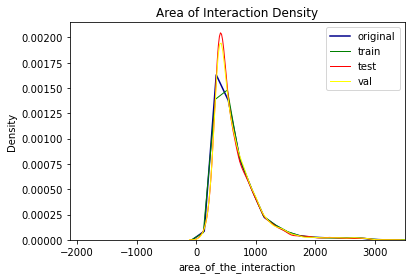

In [46]:
utils.plot_stats(df, gene_pairs_training, gene_pairs_test, gene_pairs_val, limit_plot = 100000000)

In [47]:
df_train = df[df.couples.isin(gene_pairs_training)].reset_index(drop = True)
df_val = df[df.couples.isin(gene_pairs_val)].reset_index(drop = True)
df_test = df[df.couples.isin(gene_pairs_test)].reset_index(drop = True)

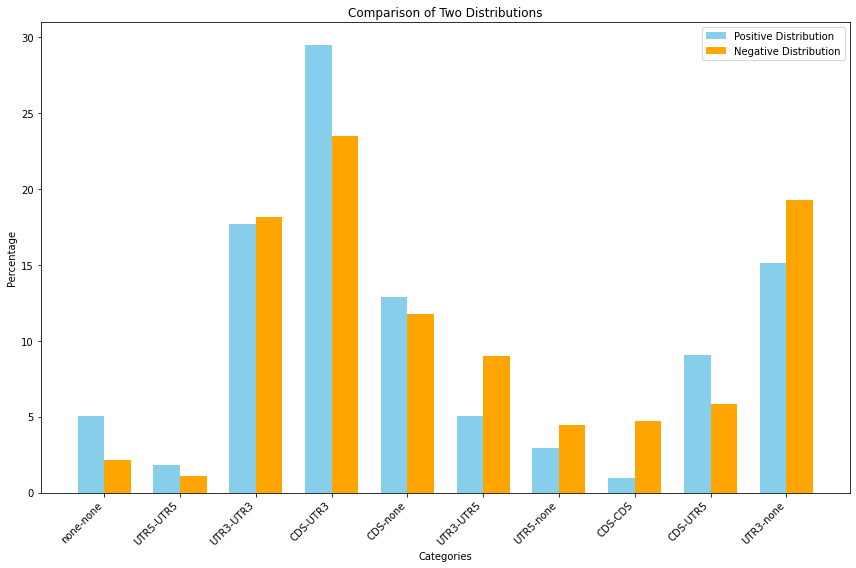

In [48]:
plot_interaction_region(df_train)

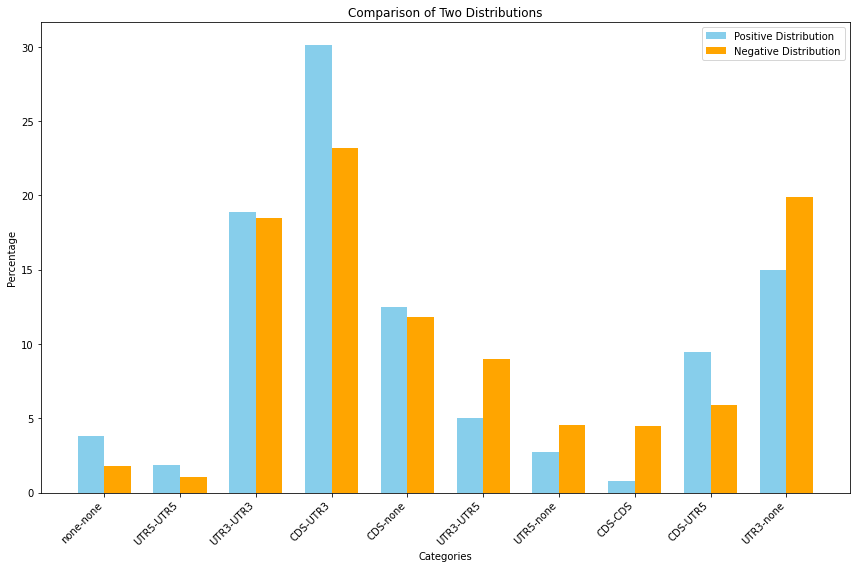

In [49]:
plot_interaction_region(df_val)

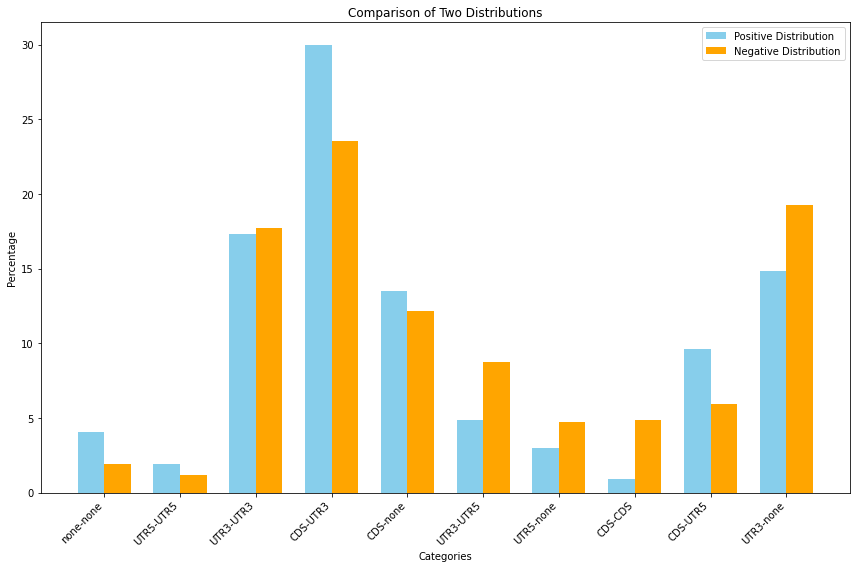

In [50]:
plot_interaction_region(df_test)

In [51]:
gene_count = obtain_gene_count_real(df)
tolerance = 10
subset = gene_count[(gene_count['diff']<tolerance)&(gene_count['diff']>-tolerance)]
subset_treshold = df_train[(df_train.gene1.isin(subset.gene)&df_train.gene2.isin(subset.gene))]

print(f'percentage of genes within the tolerance treshold {(subset.shape[0] / gene_count.shape[0]):.3f} %')
print(f'percentage of data within the tolerance treshold {(subset_treshold.shape[0] / df_train.shape[0]):.3f} %')

percentage of genes within the tolerance treshold 0.999 %
percentage of data within the tolerance treshold 0.906 %


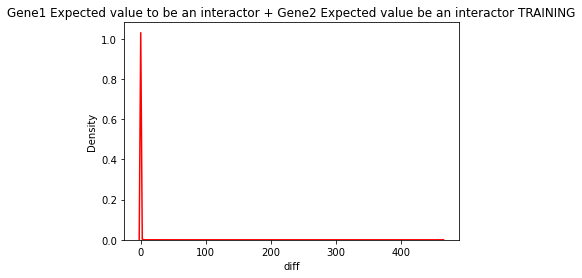

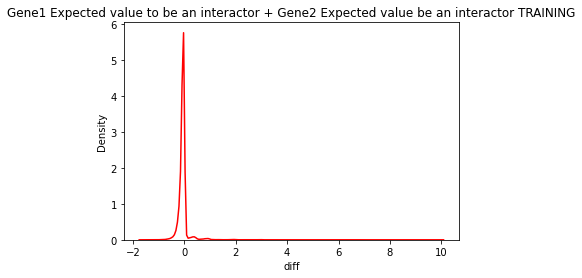

In [52]:
sns.kdeplot(gene_count['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor TRAINING')
plt.show()

sns.kdeplot(gene_count[(gene_count['diff']<tolerance)&(gene_count['diff']>-tolerance)]['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor TRAINING')
plt.show()

##### test-val creation with only the true (big) interaction regions

In [53]:
treshold = 24 #bigger than this number

def undersample(df):
    
    df = df[['couples', 'interacting']].drop_duplicates()
    
    negs = df[df.interacting == False]
    poss = df[df.interacting == True]
    
    vc = df.interacting.value_counts()
    if vc[False]>vc[True]:
        df = pd.concat([negs.sample(len(poss)), poss], axis = 0).sample(frac = 1).reset_index(drop = True)
    else:
        df = pd.concat([negs.sample(len(poss)), poss], axis = 0).sample(frac = 1).reset_index(drop = True)
        
    return df
        
df_train_sampled = df_train[(df_train.w > treshold)&(df_train.h > treshold)]
df_train_sampled = df_train_sampled[['couples', 'interacting']].drop_duplicates().reset_index(drop = True)
df_val_sampled = undersample(df_val[(df_val.w > treshold)&(df_val.h > treshold)])
df_test_sampled = undersample(df_test[(df_test.w > treshold)&(df_test.h > treshold)])

#export couples

In [54]:
df_train.interacting.value_counts()

False    114304
True      58819
Name: interacting, dtype: int64

In [55]:
df_train_sampled.interacting.value_counts()

False    17315
True     10933
Name: interacting, dtype: int64

In [56]:
df_val_sampled.interacting.value_counts()

True     2121
False    2121
Name: interacting, dtype: int64

In [57]:
df_test_sampled.interacting.value_counts()

True     2076
False    2076
Name: interacting, dtype: int64

In [58]:
gene_pairs_training = list(df_train_sampled.couples)
gene_pairs_test = list(df_test_sampled.couples)
gene_pairs_val = list(df_val_sampled.couples)

with open(os.path.join(rna_rna_files_dir, 'RANDOM', 'gene_pairs_training_HQ.txt'), "wb") as fp:   #Pickling
    pickle.dump(gene_pairs_training, fp)

with open(os.path.join(rna_rna_files_dir, 'RANDOM', 'gene_pairs_test_HQ.txt'), "wb") as fp:   #Pickling
    pickle.dump(gene_pairs_test, fp)

with open(os.path.join(rna_rna_files_dir, 'RANDOM', 'gene_pairs_val_HQ.txt'), "wb") as fp:   #Pickling
    pickle.dump(gene_pairs_val, fp)

# Create df_nt

In [2]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv')) #final_df_RANDOM
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, 'df_nt.csv'))           